##  Modeling

### 1. Import packages and load the data

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer, make_column_transformer

In [2]:
jobs = pd.read_csv('data/jobs_data_step4_features.csv')
print(jobs.info())
print('There are {} observations and {} features in this dataset.'.format(jobs.shape[0],jobs.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             1960 non-null   float64
 1   Location           2047 non-null   object 
 2   Type of ownership  2037 non-null   object 
 3   Sector             1891 non-null   object 
 4   Revenue            1471 non-null   object 
 5   Years Founded      2047 non-null   float64
 6   Min_Salary         2047 non-null   int64  
 7   Max_Salary         2047 non-null   int64  
 8   Seniority          2047 non-null   object 
 9   HQ_Same            2047 non-null   int64  
 10  SQL                2047 non-null   int64  
 11  Excel              2047 non-null   int64  
 12  Python             2047 non-null   int64  
 13  Tableau            2047 non-null   int64  
 14  R                  2047 non-null   int64  
 15  SAS                2047 non-null   int64  
dtypes: float64(2), int64(9),

In [3]:
jobs.head()

,Rating,Location,Type of ownership,Sector,Revenue,Years Founded,Min_Salary,Max_Salary,Seniority,HQ_Same,SQL,Excel,Python,Tableau,R,SAS
0,3.2,NY,Nonprofit Organization,Non-Profit,$100 to $500 million (USD),59.0,37,66,Not specified,1,1,0,1,0,1,0
1,3.8,NY,Nonprofit Organization,Health Care,$2 to $5 billion (USD),127.0,37,66,Not specified,1,1,1,0,0,1,1
2,3.4,NY,Company - Private,Information Technology,NaN,17.0,37,66,Senior,1,1,1,0,1,0,0
3,4.1,NY,Subsidiary or Business Segment,Information Technology,$50 to $100 million (USD),18.0,37,66,Not specified,0,1,0,0,1,0,0
4,3.9,NY,Company - Private,"Arts, Entertainment & Recreation",$100 to $500 million (USD),11.0,37,66,Not specified,1,1,1,1,0,0,0


### 2.Train/Test Split

In [4]:
# Split data to predict Min_Salary
X_train, X_test, y_train1, y_test1 = train_test_split(jobs.drop(columns=['Min_Salary','Max_Salary']), 
                                                    jobs.Min_Salary, test_size=0.3, random_state=47)
# Split data to predict Max_Salary
X_train, X_test, y_train2, y_test2 = train_test_split(jobs.drop(columns=['Min_Salary','Max_Salary']), 
                                                    jobs.Max_Salary, test_size=0.3, random_state=47)

In [5]:
X_train.shape, X_test.shape

((1432, 14), (615, 14))

### 3.Refining The Linear Model

In the previous step, we've tried predicting salary with a linear regression model, and now we will refine our linear regression model with feature selection and evaluate the model using cross validation.

In [6]:
categorical_features = ['HQ_Same', 'SQL', 'Excel','Python','Tableau','R','SAS',
                 'Location','Type of ownership','Sector','Revenue','Seniority']
numerical_features = ['Rating', 'Years Founded']
preprocess = make_column_transformer(
    ( make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),numerical_features),
    ( make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown='ignore')),categorical_features)
)

In [7]:
# linear regression without feature selection
pipe = make_pipeline(
    preprocess,
    LinearRegression()
)

In [8]:
pipe.fit(X_train, y_train1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Rating', 'Years Founded']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
        

In [9]:
y_tr_pred1 = pipe.predict(X_train)
y_te_pred1 = pipe.predict(X_test)

In [10]:
print('r2 score on train set: ',r2_score(y_train1, y_tr_pred1), ', r2 score on test set: ', r2_score(y_test1, y_te_pred1))
print('mae on train set: ',mean_absolute_error(y_train1, y_tr_pred1), ', mae score on test set: ', mean_absolute_error(y_test1, y_te_pred1))
print('mse on train set: ',mean_squared_error(y_train1, y_tr_pred1), ', mse score on test set: ', mean_squared_error(y_test1, y_te_pred1))

r2 score on train set:  0.3285114387876167 , r2 score on test set:  0.2845302688137007
mae on train set:  11.774820025901679 , mae score on test set:  11.980053588560361
mse on train set:  255.76167997838022 , mse score on test set:  270.5876086680645


In [11]:
# Assessing performance using cross-validation
cv_results = cross_validate(pipe, X_train, y_train1, cv=5)
cv_scores = cv_results['test_score']
cv_scores

array([0.33482974, 0.26864631, 0.24532448, 0.23206794, 0.13907614])

In [12]:
np.mean(cv_scores),np.std(cv_scores)

(0.24398892417645413, 0.06326235299436937)

In [13]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.12, 0.37])

### 2.Lasso

In [19]:
# Lasso with alpha = 1.0 (default)
lasso_pipe = make_pipeline(
    preprocess,
    Lasso()
)

In [20]:
# Assessing performance using cross-validation
cv_results_lasso = cross_validate(lasso_pipe, X_train, y_train1, cv=5)
cv_scores_lasso = cv_results_lasso['test_score']
cv_scores_lasso

array([0.15491287, 0.15389161, 0.12963258, 0.13355017, 0.11548106])

In [21]:
np.mean(cv_scores_lasso),np.std(cv_scores_lasso)

(0.1374936596100442, 0.015061368413500519)

The default Lasso regression model yields worse performance than the linear regression model. Let's try tuning Lasso hyperparameters to see if we can get a better result.

#### Hyperparameter search using GridSearchCV

We now create a pipeline that
- imputes missing values
- scales the data
- selects the k best features
- trains a linear regression model 

And we use cross-validation for estimating model performance and pick the value of k that gives the best performance.

In [14]:
pipe_k = make_pipeline(
    preprocess,
    SelectKBest(f_regression),
    LinearRegression()
)

In [15]:
# list the names of all the parameters in a pipeline
pipe_k.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'selectkbest', 'linearregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__pipeline-1', 'columntransformer__pipeline-2', 'columntransformer__pipeline-1__memory', 'columntransformer__pipeline-1__steps', 'columntransformer__pipeline-1__verbose', 'columntransformer__pipeline-1__simpleimputer', 'columntransformer__pipeline-1__standardscaler', 'columntransformer__pipeline-1__simpleimputer__add_indicator', 'columntransformer__pipeline-1__simpleimputer__copy', 'columntransformer__pipeline-1__simpleimputer__fill_value', 'columntransformer__pipeline-1__simpleimputer__missing_values', 'columntransformer__pipeline-1__simpleimputer__strategy', 'columntransformer__pipeline-1__simpleimputer__verbose', 'columntransformer__pipeline-1__standardscaler__copy',

In [16]:
# define a range of k to investigate
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [17]:
lr_grid_cv = GridSearchCV(pipe_k, param_grid=grid_params, cv=5, n_jobs=-1)

In [18]:
lr_grid_cv.fit(X_train, y_train1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Rating',
                                                                          'Years '
                                                                          'Founded']),
                                                                        ('pipeline-2',
                                         

In [19]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [20]:
print('best k: ',lr_grid_cv.best_params_)

best k:  {'selectkbest__k': 12}


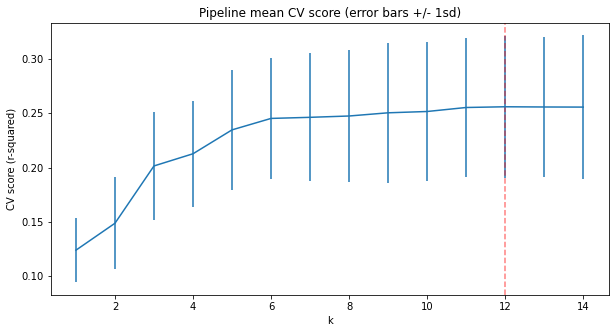

In [21]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 12.

#### Which features were most useful? 

In [53]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True,  True, False,  True,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True])

In [23]:
df=make_pipeline(preprocess).fit_transform(X_train)

In [24]:
df.todense()

matrix([[ 0.2549982 , -0.63529049,  0.        , ...,  0.        ,
          1.        ,  0.        ],
        [-0.05224406, -0.51201321,  1.        , ...,  0.        ,
          1.        ,  0.        ],
        [ 1.33034608, -0.65830225,  1.        , ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [-0.51310743, -0.81938456,  1.        , ...,  0.        ,
          0.        ,  1.        ],
        [-1.28121307,  0.86047382,  1.        , ...,  0.        ,
          1.        ,  0.        ],
        [ 1.02310383, -0.01397301,  0.        , ...,  0.        ,
          0.        ,  1.        ]])

In [54]:
df.shape

(1432, 86)

In [51]:
# Get the linear model coefficients
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
#pd.Series(coefs, index=features).sort_values(ascending=False) #abs

IndexError: boolean index did not match indexed array along dimension 0; dimension is 14 but corresponding boolean dimension is 86

In [31]:
pipe_k.named_steps['preprocess'][1].named_steps['onehot'].get_feature_names(categorical_features)

KeyError: 'preprocess'

### 4.Random Forest Model

In [34]:
# Define the pipeline for a random forest base model
rf_pipe = make_pipeline(
    preprocess,
    RandomForestRegressor(random_state=47)
)

In [35]:
rf_default_cv_results = cross_validate(rf_pipe, X_train, y_train1, cv=5)

In [36]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.27697319, 0.23350682, 0.22367662, 0.13702231, 0.00042933])

In [37]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.17432165442000916, 0.09808762916537621)

The test score doesn't seem good enough. Random forest has a number of hyperparameters that can be explored, so let's see how we can improve this model by tuning the hyperparameters.

#### Hyperparameter search using RandomizedSearchCV

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
bootstrap = [True, False]

random_grid = {
        'randomforestregressor__n_estimators': n_estimators,
        'randomforestregressor__max_features': max_features,
        'randomforestregressor__bootstrap': bootstrap
}
random_grid

{'randomforestregressor__n_estimators': [20,
  240,
  460,
  680,
  900,
  1120,
  1340,
  1560,
  1780,
  2000],
 'randomforestregressor__max_features': ['auto', 'sqrt'],
 'randomforestregressor__bootstrap': [True, False]}

In [39]:
rf_random_cv = RandomizedSearchCV(estimator = rf_pipe, param_distributions = random_grid, cv = 5, n_jobs = -1)

In [40]:
rf_random_cv.fit(X_train, y_train1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Rating',
                                                                                'Years '
                                                                                'Founded']),
                                                                    

In [41]:
rf_random_cv.best_params_

{'randomforestregressor__n_estimators': 1560,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__bootstrap': True}

From these results, we should be able to narrow the range of values for each hyperparameter.

#### Evaluate Random Search

To determine if random search yielded a better model, we compare our random forest base model with the best random search model.

In [42]:
rf_random_best_cv_results = cross_validate(rf_random_cv.best_estimator_, X_train, y_train1, cv=5)
rf_random_best_scores = rf_random_best_cv_results['test_score']
rf_random_best_scores

array([0.30795372, 0.2550128 , 0.21293896, 0.19710488, 0.09104955])

In [43]:
np.mean(rf_random_best_scores), np.std(rf_random_best_scores)

(0.2128119817522763, 0.07198010501515933)

Recall that our random forest base model gave a mean test score of 0.17432165442000916 and 0.09808762916537621 standard deciation. Comparing to the random forest base model, the random search we've done yielded a better result.  
We can further improve our results by using grid search to focus on the most promising hyperparameters ranges found in the random search.

#### Hyperparameter search using GridSearchCV

In [44]:
rf_param_grid = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_features': ['sqrt'],
    'randomforestregressor__n_estimators': [50,100,150,200,250,300,350,400,450]
}
rf_param_grid

{'randomforestregressor__bootstrap': [True],
 'randomforestregressor__max_features': ['sqrt'],
 'randomforestregressor__n_estimators': [50,
  100,
  150,
  200,
  250,
  300,
  350,
  400,
  450]}

In [45]:
rf_grid_cv = GridSearchCV(rf_pipe, param_grid=rf_param_grid, cv=5, n_jobs=-1)

In [46]:
rf_grid_cv.fit(X_train, y_train1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Rating',
                                                                          'Years '
                                                                          'Founded']),
                                                                        ('pipeline-2',
                                         

In [47]:
rf_grid_cv.best_params_

{'randomforestregressor__bootstrap': True,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__n_estimators': 200}

In [48]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train1, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.3154143 , 0.24523   , 0.2171011 , 0.20338711, 0.0956918 ])

In [49]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.21536486014321046, 0.07123192889769354)

ValueError: Length of passed values is 86, index implies 14.

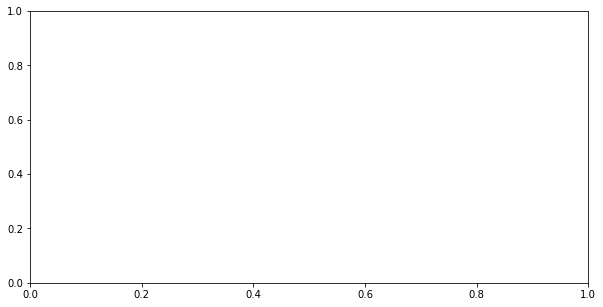

In [50]:
#Plot a barplot of the random forest's feature importances
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [55]:
imps

array([9.87637021e-02, 1.09123191e-01, 1.56262601e-02, 1.63314185e-02,
       1.85539833e-02, 1.74811267e-02, 1.89019123e-02, 1.77057689e-02,
       1.24726661e-02, 1.28438631e-02, 1.41732329e-02, 1.49364490e-02,
       1.01812351e-02, 1.04826495e-02, 1.06007906e-02, 1.08376744e-02,
       3.84170343e-03, 9.44795862e-02, 7.98568271e-03, 5.80665607e-04,
       4.17127895e-03, 1.39919749e-03, 3.57019116e-02, 8.39970433e-03,
       2.00846082e-04, 2.93139832e-03, 8.69885419e-03, 1.50306574e-02,
       1.64711455e-02, 7.28872388e-03, 3.61074518e-05, 4.37075980e-02,
       1.90983384e-02, 2.30680007e-03, 4.39498085e-03, 1.18117700e-03,
       1.68382097e-02, 1.31352970e-02, 9.34313496e-04, 1.02510089e-04,
       1.57131427e-03, 2.05000124e-03, 8.87922550e-03, 1.12830440e-03,
       1.58304951e-03, 6.85485462e-04, 2.42586819e-04, 7.47530361e-03,
       7.79795325e-03, 2.56408471e-03, 2.07101861e-03, 3.65684247e-03,
       1.51174053e-02, 1.67265430e-03, 7.81292248e-04, 2.68083403e-03,
      